### 1. Download data

In [ ]:
!wget https://opendata.rijdendetreinen.nl/public/tariff-distances/tariff-distances-2022-01.csv -O ./data_hw/distances-2022.csv

!wget https://opendata.rijdendetreinen.nl/public/stations/stations-2023-09-nl.csv -O ./data_hw/stations-2023.csv
!wget -r -l1 -A "*.csv" -nd -P ./data_hw/disruptions/ https://opendata.rijdendetreinen.nl/public/disruptions/ ./data_hw/disruptions/

!wget https://opendata.rijdendetreinen.nl/public/services/services-2023.csv.gz -O ./data_hw/services-2023.csv.gz
!gunzip ./data_hw/services-2023.csv.gz
!wget https://opendata.rijdendetreinen.nl/public/services/services-2022.csv.gz -O ./data_hw/services-2022.csv.gz
!gunzip ./data_hw/services-2022.csv.gz
!wget https://opendata.rijdendetreinen.nl/public/services/services-2021.csv.gz -O ./data_hw/services-2021.csv.gz
!gunzip ./data_hw/services-2021.csv.gz
!wget https://opendata.rijdendetreinen.nl/public/services/services-2020.csv.gz -O ./data_hw/services-2020.csv.gz
!gunzip ./data_hw/services-2020.csv.gz
!wget https://opendata.rijdendetreinen.nl/public/services/services-2019.csv.gz -O ./data_hw/services-2019.csv.gz
!gunzip ./data_hw/services-2019.csv.gz

### * reset tables if you want to do so

In [11]:
import duckdb

!rm -rf data_hw/db/railway.duckdb

db = duckdb.connect(database=':memory:')

### 2. Stations table

In [12]:
import duckdb
db = duckdb.connect('data_hw/db/railway.duckdb')
db.sql("""
    CREATE TABLE stations AS
    SELECT *
    FROM './data_hw/stations-2023.csv'
""")

In [18]:
db.sql("""
    SELECT COUNT(*) 
    FROM stations
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          397 │
└──────────────┘

### 3. Distances and distances long

In [ ]:
db.sql("""
db_distances.execute("""
    CREATE TABLE distances AS
    SELECT *
    FROM READ_CSV('data_hw/distances-2022.csv',
    nullstr='XXX'
    )
""")

CatalogException: Catalog Error: Table with name "distances" already exists!

In [14]:
db.sql("""
    CREATE TABLE distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
""")

In [15]:
db.sql("""
    SELECT * FROM distances_LONG LIMIT 5
""")

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ AC      │ AH            │       82 │
│ AC      │ AHP           │       83 │
│ AC      │ AHPR          │       85 │
│ AC      │ AHZ           │       90 │
│ AC      │ AKL           │       71 │
└─────────┴───────────────┴──────────┘

### 4. Distruptions table

In [20]:
db.sql("""
       CREATE TABLE disruptions AS
       SELECT *
       FROM READ_CSV_AUTO('data_hw/disruptions/*.csv')
""")

CatalogException: Catalog Error: Table with name "disruptions" already exists!

In [21]:
db.sql("""
    SELECT count(*) FROM disruptions
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│        55864 │
└──────────────┘

In [22]:
db.sql("""
    COPY(
       SELECT * FROM read_csv_auto('data_hw/services-*.csv'))
       TO './data_hw/services.parquet' (FORMAT PARQUET);
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [23]:
db.sql("""
       CREATE TABLE services AS
       SELECT * FROM read_parquet('./data_hw/services.parquet')
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [26]:
db.sql("""
       SELECT COUNT(*) FROM services
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│    108092099 │
└──────────────┘

### 7. Analytical queries
#### 7.1. Amsterdam total departures

In [27]:
db.sql("""
    SELECT COUNT(*) AS ams_total_departures
    FROM services
    WHERE "Stop:Station name" = 'Amsterdam Centraal'
      AND "Stop:Departure time" IS NOT NULL;
""")

┌──────────────────────┐
│ ams_total_departures │
│        int64         │
├──────────────────────┤
│              1400872 │
└──────────────────────┘

#### 7.2. Avg delay per service type

In [28]:
db.sql("""
SELECT 
    "Service:Type" AS service_type,
    AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
GROUP BY service_type
ORDER BY avg_arrival_delay DESC;
""")

┌──────────────────────┬────────────────────┐
│     service_type     │ avg_arrival_delay  │
│       varchar        │       double       │
├──────────────────────┼────────────────────┤
│ Alpen Express        │  31.84254143646409 │
│ Krokus Express       │ 18.304347826086957 │
│ European Sleeper     │  9.844229217110573 │
│ Nightjet             │   8.98285040323866 │
│ Eurostar             │  5.654954782656212 │
│ Thalys               │ 5.3961896909446025 │
│ ICE International    │  4.954097742589189 │
│ Int. Trein           │   4.95267696009625 │
│ Nachttrein           │  4.725949878738884 │
│ Stoomtrein           │ 3.1575757575757577 │
│     ·                │                 ·  │
│     ·                │                 ·  │
│     ·                │                 ·  │
│ Tram ipv trein       │                0.0 │
│ Stopbus ipv trein    │                0.0 │
│ stoptrein            │                0.0 │
│ Metro i.p.v. trein   │                0.0 │
│ Niet instappen       │          

#### 7.3. Most common delay cause by year

In [29]:
db.sql("""
    SELECT 
    EXTRACT(YEAR FROM "start_time") AS year,
    mode("cause_en") AS most_common_cause
FROM disruptions
GROUP BY year
ORDER BY year;
""")

┌───────┬───────────────────┐
│ year  │ most_common_cause │
│ int64 │      varchar      │
├───────┼───────────────────┤
│  2011 │ broken down train │
│  2012 │ points failure    │
│  2013 │ points failure    │
│  2014 │ broken down train │
│  2015 │ broken down train │
│  2016 │ broken down train │
│  2017 │ broken down train │
│  2018 │ broken down train │
│  2019 │ broken down train │
│  2020 │ broken down train │
│  2021 │ broken down train │
│  2022 │ broken down train │
│  2023 │ broken down train │
│  2024 │ broken down train │
├───────┴───────────────────┤
│ 14 rows         2 columns │
└───────────────────────────┘

#### 7.4. How many trains departed overall from AMS

In [30]:
db.sql("""
SELECT COUNT(DISTINCT "Service:RDT-ID") AS amsterdam_starts
FROM services
WHERE "Stop:Arrival time" IS NULL
  AND "Stop:Station name" ILIKE 'Amsterdam%';
""")

┌──────────────────┐
│ amsterdam_starts │
│      int64       │
├──────────────────┤
│           914772 │
└──────────────────┘

#### 7.5. Percentage of trains going outside Netherlands

Remark: I've checked stations-2023.csv manually and it seems that there no stations outside NL(also confirmed by queries)

In [31]:
db.sql("""
SELECT  * FROM stations where country <>'NL'
""")

┌───────┬─────────┬───────┬────────────┬─────────────┬───────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  id   │  code   │  uic  │ name_short │ name_medium │ name_long │  slug   │ country │  type   │ geo_lat │ geo_lng │
│ int64 │ varchar │ int64 │  varchar   │   varchar   │  varchar  │ varchar │ varchar │ varchar │ double  │ double  │
├───────┴─────────┴───────┴────────────┴─────────────┴───────────┴─────────┴─────────┴─────────┴─────────┴─────────┤
│                                                      0 rows                                                      │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [32]:
db.sql("""
    WITH final_stops AS (
    SELECT DISTINCT "Service:RDT-ID", "Country"
    FROM services
    INNER JOIN stations ON ("Stop:Station code" = "code")
    WHERE "Stop:Departure time" IS NULL
)
SELECT 
    ROUND(
        SUM(CASE WHEN "Country" <> 'NL' THEN 1 ELSE 0 END) * 1.0 / COUNT(*),
        3
    ) AS fraction_outside_nl
FROM final_stops;
""")

┌─────────────────────┐
│ fraction_outside_nl │
│       double        │
├─────────────────────┤
│                 0.0 │
└─────────────────────┘

#### 7.6. Max distance between Netherland's stations

In [33]:
db.sql("""
       SELECT MAX(distance) AS max_distance_nl
        FROM distances_long
        JOIN stations ON (other_station = code)
        WHERE country ='NL'
""")

┌─────────────────┐
│ max_distance_nl │
│      int64      │
├─────────────────┤
│             450 │
└─────────────────┘

#### 7.7. Avg. delay by service operator - bar plot

Remark - removed operators with Avg. delay = 0

<Axes: title={'center': 'Average Arrival Delay by Operator(Ommited operators without delay)'}, xlabel='Operator', ylabel='Average Arrival Delay (minutes)'>

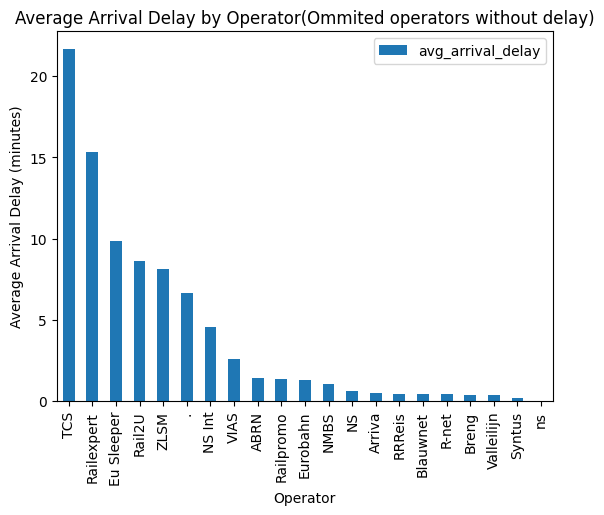

In [34]:
df = db.sql("""
            SELECT 
    "Service:Company" AS operator,
    AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
GROUP BY operator
ORDER BY avg_arrival_delay DESC;
""").df()

df = df[df['avg_arrival_delay']>0]
df.plot.bar(x='operator', y='avg_arrival_delay', title='Average Arrival Delay by Operator(Ommited operators without delay)', xlabel='Operator', ylabel='Average Arrival Delay (minutes)')

#### 7.8. Num of distraptions per year - line plot

<Axes: title={'center': 'Number of Disruptions per Year'}, xlabel='Year', ylabel='Number of Disruptions'>

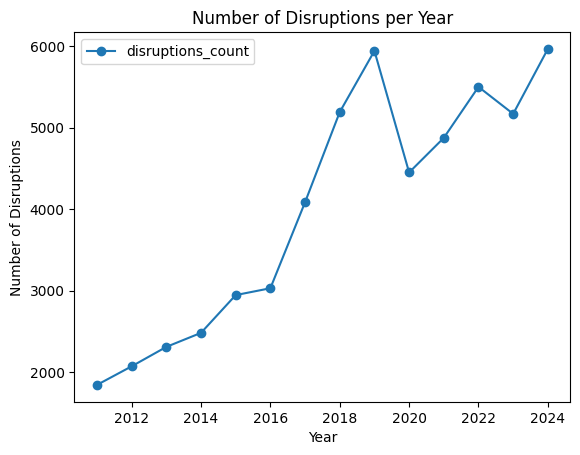

In [35]:
df = db.sql("""
    SELECT EXTRACT(YEAR FROM "start_time") AS year,
           COUNT(*) AS disruptions_count
    FROM disruptions
    GROUP BY year
    ORDER BY year
""").df()

df.plot.line(x='year', y='disruptions_count', title='Number of Disruptions per Year', 
             xlabel='Year', ylabel='Number of Disruptions', marker='o')

#### 7.9. - Fraction of completely cancelled services per year - line plot

<Axes: title={'center': 'Fraction of Completely Cancelled Services per Year'}, xlabel='Year', ylabel='Fraction of Cancelled Services'>

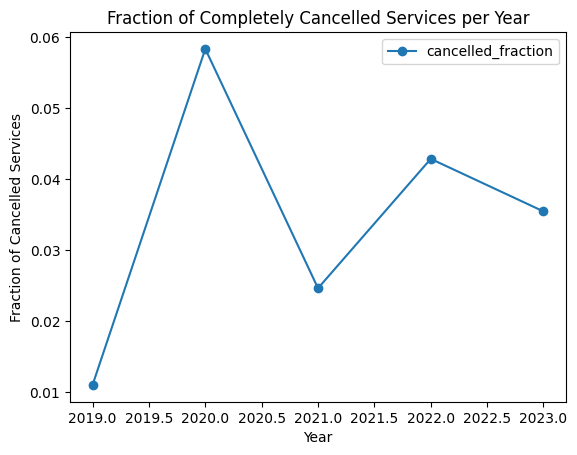

In [36]:
df = db.sql("""
SELECT 
    EXTRACT(YEAR FROM "Service:Date") AS year,
    AVG(CASE WHEN "Service:Completely cancelled" THEN 1.0 ELSE 0.0 END) AS cancelled_fraction
FROM services
GROUP BY year
ORDER BY year;
""").df()

df.plot.line(x='year', y='cancelled_fraction', title='Fraction of Completely Cancelled Services per Year',
                xlabel='Year', ylabel='Fraction of Cancelled Services', marker='o')

### 8. Service connections(at least try)

In [ ]:
db.sql("""
       CREATE TABLE station_connections AS
WITH station_pairs AS (
    SELECT
        "Service:RDT-ID" AS service_id,
        "Stop:Station code" AS start_station_code,
        LEAD("Stop:Station code") OVER (
            PARTITION BY "Service:RDT-ID"
            ORDER BY "Stop:Departure time"
        ) AS end_station_code
    FROM services
    WHERE "Stop:Departure time" IS NOT NULL
),
deduplicated_pairs AS (
    SELECT DISTINCT
        service_id,
        CASE WHEN start_station_code < end_station_code THEN start_station_code ELSE end_station_code END AS start_station_code,
        CASE WHEN start_station_code < end_station_code THEN end_station_code ELSE start_station_code END AS end_station_code
    FROM station_pairs
    WHERE end_station_code IS NOT NULL
)
SELECT 
    p.service_id,
    p.start_station_code,
    p.end_station_code,
    d.distance
FROM deduplicated_pairs p
JOIN distances_long d
  ON (
      (p.start_station_code = d.Station AND p.end_station_code = d.other_station)
      ORjyu766666666666666666666
      (p.start_station_code = d.other_station AND p.end_station_code = d.Station)
  );

       """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))